In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, DepthwiseConv2D, GlobalAveragePooling2D, Dropout, Dense, Input, Add, Multiply
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model

**Auxiliary Functions**

In [2]:
def data_visualization(classes, data):
    fig, ax = plt.subplots(figsize=(9, 5))
    ax.bar(classes, data)
    ax.set(title="Dataset's distribution for each Emotion class")
    ax.set(xlabel="Emotions", ylabel="#Images")
    ax.grid()

def load_data(data_path):
    subfolders_ck = os.listdir(data_path)
    print("[INFO] Dataset Loading...\n")

    img_data_list = []
    labels_list = []
    num_images_per_class = []

    for category in subfolders_ck:
        img_list = os.listdir(data_path + '/' + category)
        print('Loading :', len(img_list), 'images of category', category)
        for img in img_list:
            pixels = cv2.imread(data_path + '/' + category + '/' + img)
            face_array = cv2.resize(pixels, (48, 48), interpolation=cv2.INTER_CUBIC)
            img_data_list.append(face_array)
            labels_list.append(category)
        num_images_per_class.append(len(img_list))

    data = np.array(img_data_list)
    le = LabelEncoder()
    labels = le.fit_transform(labels_list)
    labels = to_categorical(labels, len(subfolders_ck))

    data_visualization(subfolders_ck, num_images_per_class)
    print("\nTotal number of uploaded data: ", data.shape[0], ", with data shape", (data.shape[1], data.shape[2], data.shape[3]))
    return data, labels


**Load and Preprocess Data**

[INFO] Dataset Loading...

Loading : 12259 images of category happy
Loading : 8869 images of category sad
Loading : 7273 images of category fear
Loading : 7210 images of category surprise
Loading : 10038 images of category neutral
Loading : 7213 images of category angry
Loading : 2913 images of category disgust

Total number of uploaded data:  55775 , with data shape (48, 48, 3)


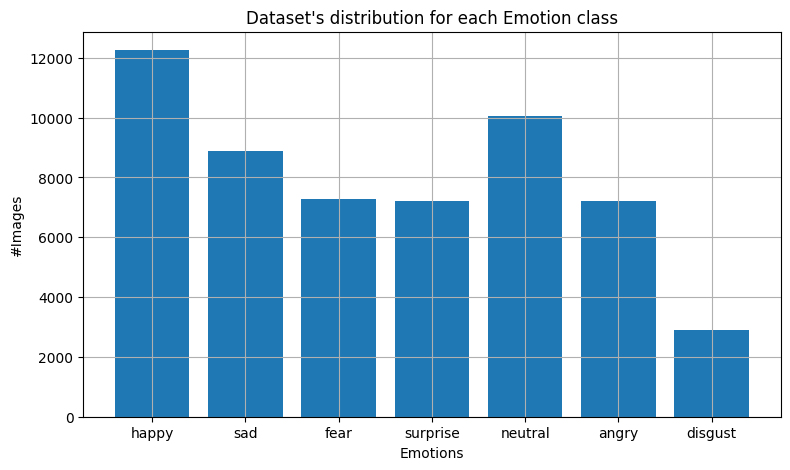

In [3]:
# Load and preprocess the data
data_path_ck = "./mixed_data/train/"
data, labels = load_data(data_path_ck)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, shuffle=True, random_state=3)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=True, random_state=3)

# Data augmentation
trainAug = ImageDataGenerator(rotation_range=15, zoom_range=0.15, brightness_range=(.6, 1.2), shear_range=.15, horizontal_flip=True, fill_mode="nearest")


**Model Definition**

In [4]:
# Define a Swish activation function
def swish(x):
    return x * tf.keras.backend.sigmoid(x)

# Define a squeeze-and-excitation block
def se_block(input_tensor, reduction=4):
    filters = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Dense(filters // reduction, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    se = Multiply()([input_tensor, se])
    return se

# Define the custom EfficientNet-like model
def build_model(input_shape=(48, 48, 3), num_classes=7):
    inputs = Input(shape=input_shape)
    
    # First Conv Layer
    x = Conv2D(32, (3, 3), strides=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation(swish)(x)
    
    # Depthwise Separable Convolutions with SE blocks
    def mb_conv_block(x, filters, kernel_size, strides, expansion_factor):
        input_channels = x.shape[-1]
        x = Conv2D(input_channels * expansion_factor, (1, 1), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation(swish)(x)
        
        x = DepthwiseConv2D(kernel_size, strides=strides, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation(swish)(x)
        
        x = Conv2D(filters, (1, 1), padding='same')(x)
        x = BatchNormalization()(x)
        
        x = se_block(x)
        
        if strides == 1 and input_channels == filters:
            x = Add()([inputs, x])
        return x

    # Stack of MBConv blocks
    x = mb_conv_block(x, 16, (3, 3), 1, 1)
    x = mb_conv_block(x, 24, (3, 3), 2, 6)
    x = mb_conv_block(x, 40, (5, 5), 2, 6)
    x = mb_conv_block(x, 80, (3, 3), 2, 6)
    x = mb_conv_block(x, 112, (5, 5), 1, 6)
    x = mb_conv_block(x, 192, (5, 5), 2, 6)
    x = mb_conv_block(x, 320, (3, 3), 1, 6)
    
    # Final layers
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create an object of the model
model = build_model()

# Save the summary and the plot of the model into files
from contextlib import redirect_stdout
with open('modelsummary.txt', 'w') as f:
    with redirect_stdout(f):
        model.summary()
plot_model(model, to_file='model.png')


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


**Model Training**

In [5]:
# Train the model
EPOCHS = 100
batch_size = 32
filepath = "./checkpoints/weights.best.hdf5"

# Define the necessary callbacks
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystopping = EarlyStopping(monitor='val_accuracy', patience=15, verbose=1, mode='auto', restore_best_weights=True)
rlrop = ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-6, verbose=1)

callbacks = [checkpoint, earlystopping, rlrop]

print(f"[INFO] training network for {EPOCHS} epochs...\n")
hist = model.fit(trainAug.flow(X_train, y_train, batch_size=batch_size), steps_per_epoch=len(X_train) // batch_size, validation_data=(X_valid, y_valid), epochs=EPOCHS, callbacks=callbacks)


[INFO] training network for 100 epochs...

Epoch 1/100
1220/1220 [==============================] - ETA: 0s - loss: 1.6953 - accuracy: 0.3154
Epoch 1: val_accuracy improved from -inf to 0.40688, saving model to ../checkpoints/weights.best.hdf5
1220/1220 [==============================] - 80s 64ms/step - loss: 1.6953 - accuracy: 0.3154 - val_loss: 1.4950 - val_accuracy: 0.4069 - lr: 0.0010
Epoch 2/100
   1/1220 [..............................] - ETA: 1:37 - loss: 1.5388 - accuracy: 0.3438

/Users/pedro/Desktop/CV_Project/venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1220/1220 [==============================] - ETA: 0s - loss: 1.4560 - accuracy: 0.4206
Epoch 2: val_accuracy improved from 0.40688 to 0.41477, saving model to ../checkpoints/weights.best.hdf5
1220/1220 [==============================] - 79s 65ms/step - loss: 1.4560 - accuracy: 0.4206 - val_loss: 1.4742 - val_accuracy: 0.4148 - lr: 0.0010
Epoch 3/100
1220/1220 [==============================] - ETA: 0s - loss: 1.3780 - accuracy: 0.4541
Epoch 3: val_accuracy improved from 0.41477 to 0.47514, saving model to ../checkpoints/weights.best.hdf5
1220/1220 [==============================] - 80s 66ms/step - loss: 1.3780 - accuracy: 0.4541 - val_loss: 1.3432 - val_accuracy: 0.4751 - lr: 0.0010
Epoch 4/100
1220/1220 [==============================] - ETA: 0s - loss: 1.3266 - accuracy: 0.4763
Epoch 4: val_accuracy did not improve from 0.47514
1220/1220 [==============================] - 81s 66ms/step - loss: 1.3266 - accuracy: 0.4763 - val_loss: 1.3270 - val_accuracy: 0.4751 - lr: 0.0010
Epoch 5/10

**Plot Learning Curves**

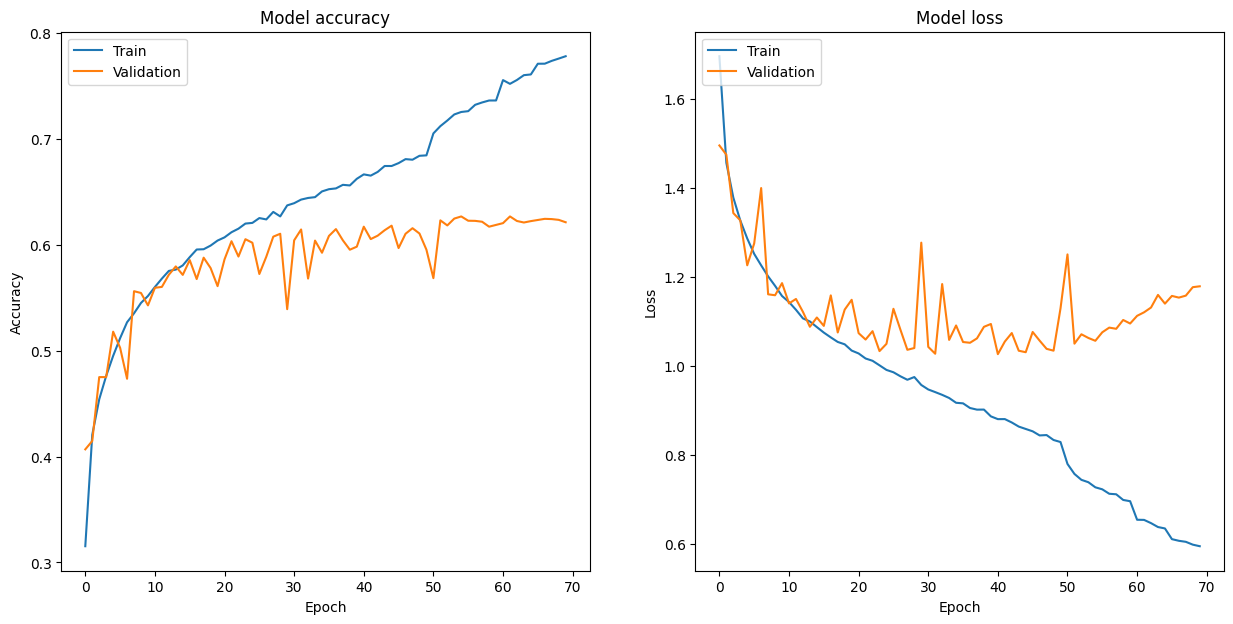

In [9]:
# Plot the learning curves
fig = plt.figure(figsize=(15, 7))
fig.add_subplot(121)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('Training_Validation_Accuracy_Plot.png')

fig.add_subplot(122)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('Training_Validation_Loss_Plot.png')

In [15]:
final_model_path = "./final_model.h5"  # Path to save the final model
model.save(final_model_path)

**Model Evaluation**

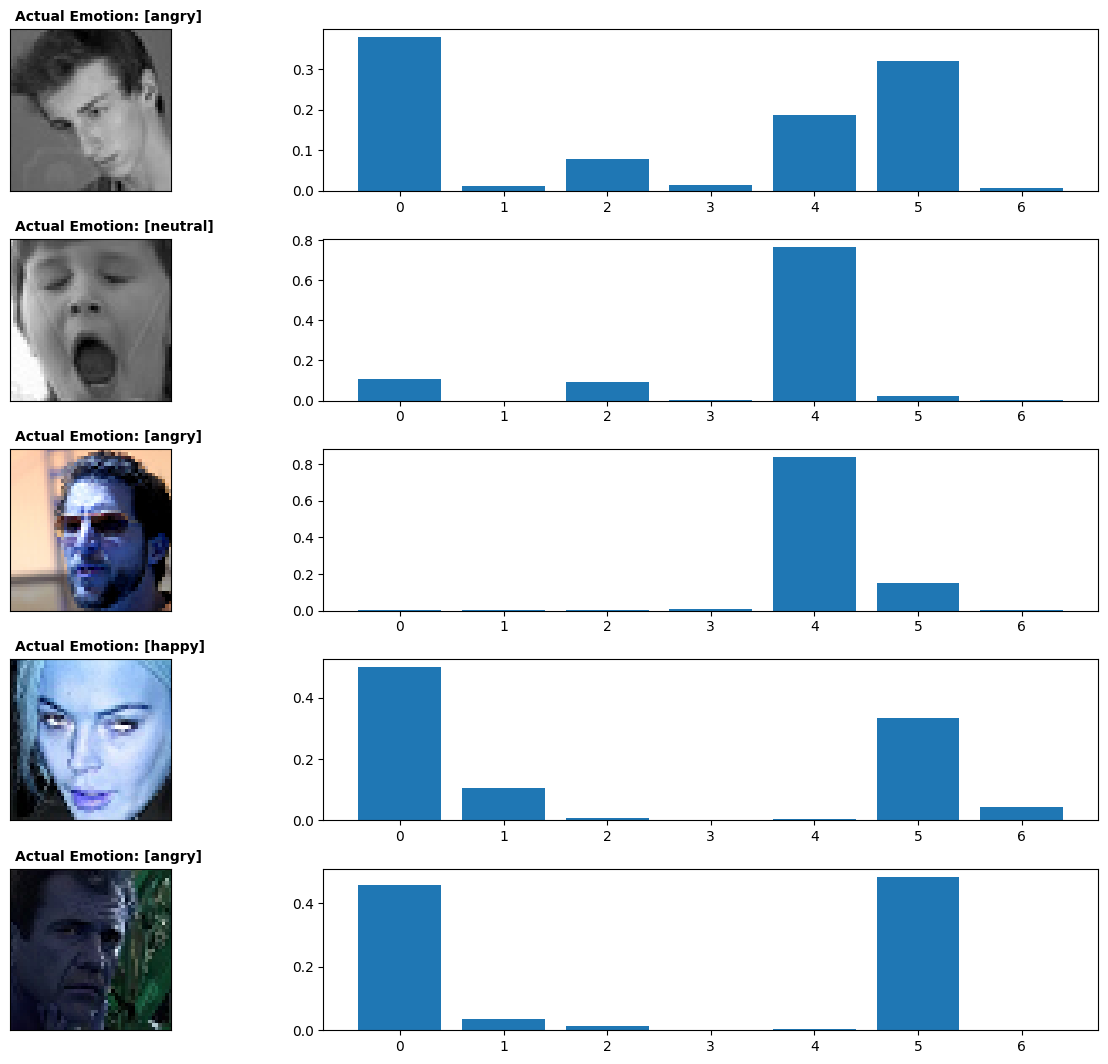

In [16]:
# Load the weights with which the model managed to achieve the highest validation accuracy
model.load_weights(final_model_path)

# Predict and visualize results
samples = np.random.choice(len(X_test), 5)
predictions = model.predict(X_test[samples], verbose=0)
fig, axes = plt.subplots(len(samples), 2, figsize=(18, 13))
fig.subplots_adjust(hspace=0.3, wspace=-0.2)

mapping = ['happy', 'sad', 'fear', 'surprise', 'neutral', 'angry', 'disgust'] 

for i, (prediction, image, label) in enumerate(zip(predictions, X_test[samples], y_test[samples])):
    axes[i, 0].imshow(np.squeeze(image / 255.))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(1., -3, f'Actual Emotion: [{mapping[np.argmax(label)]}]', weight='bold')
    axes[i, 1].bar(np.arange(len(prediction)), prediction)
    axes[i, 1].set_xticks(np.arange(len(prediction)))


In [17]:
import tensorflow as tf

model = tf.keras.models.load_model('./checkpoints/weights.best.hdf5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/bz/dmt639hd4zqck2f7f3v313j00000gn/T/tmp4nr5j4za/assets


INFO:tensorflow:Assets written to: /var/folders/bz/dmt639hd4zqck2f7f3v313j00000gn/T/tmp4nr5j4za/assets
2024-06-20 16:39:45.307343: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-06-20 16:39:45.307529: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-06-20 16:39:45.308335: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/bz/dmt639hd4zqck2f7f3v313j00000gn/T/tmp4nr5j4za
2024-06-20 16:39:45.319474: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2024-06-20 16:39:45.319489: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /var/folders/bz/dmt639hd4zqck2f7f3v313j00000gn/T/tmp4nr5j4za
2024-06-20 16:39:45.350098: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2024-06-20 16:39:45.363564: I tensorflow/cc/saved_model/load

4297628